In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time
import scipy.stats as st
from scipy.stats import linregress

In [2]:
# Focus on major fire incident: Read in csv file
major_fire_data = '../output_data/major_fire.csv'
major_fire_df = pd.read_csv(major_fire_data)
major_fire_df.head()

,AcresBurned,AirTankers,ArchiveYear,Counties,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Days Burned,...,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,WaterTenders,Started Month
0,24251.0,NaN,2013,Ventura,56,47.0,8.0,117.0,5/11/13,9,...,Springs Fire,2167.0,5/2/13,6.0,10.0,NaN,NaN,46731fb8-3350-4920-bdf7-910ac0eb715c,11.0,5
1,20292.0,NaN,2013,Riverside,33,63.0,20.0,201.0,8/12/13,5,...,Silver Fire,2106.0,8/7/13,8.0,40.0,NaN,NaN,c400203b-a7fd-4bd8-803a-f3c74bc32a2b,20.0,8
2,11429.0,NaN,2013,Tehama,52,30.0,3.0,36.0,8/29/13,6,...,Deer Fire,898.0,8/23/13,NaN,NaN,NaN,NaN,956dbcf6-db40-4b61-b235-4ede14738f1e,8.0,8
3,8073.0,NaN,2013,Shasta,45,12.0,3.0,30.0,9/15/13,6,...,Clover Fire,342.0,9/9/13,10.0,201.0,NaN,NaN,92af9783-eda9-4186-afe9-447f61a92636,NaN,9
4,7055.0,NaN,2013,San Diego,37,56.0,24.0,183.0,7/15/13,9,...,Chariot Fire,2147.0,7/6/13,9.0,149.0,NaN,NaN,ee19b2ec-a96a-4738-994e-fb3ea016e053,24.0,7


In [3]:
# Duplicated data removed process
final_burned_df = major_fire_df.drop_duplicates(subset=['UniqueId', 'Days Burned','AcresBurned'])
final_burned_df.head()

,AcresBurned,AirTankers,ArchiveYear,Counties,CountyIds,CrewsInvolved,Dozers,Engines,Extinguished,Days Burned,...,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,WaterTenders,Started Month
0,24251.0,NaN,2013,Ventura,56,47.0,8.0,117.0,5/11/13,9,...,Springs Fire,2167.0,5/2/13,6.0,10.0,NaN,NaN,46731fb8-3350-4920-bdf7-910ac0eb715c,11.0,5
1,20292.0,NaN,2013,Riverside,33,63.0,20.0,201.0,8/12/13,5,...,Silver Fire,2106.0,8/7/13,8.0,40.0,NaN,NaN,c400203b-a7fd-4bd8-803a-f3c74bc32a2b,20.0,8
2,11429.0,NaN,2013,Tehama,52,30.0,3.0,36.0,8/29/13,6,...,Deer Fire,898.0,8/23/13,NaN,NaN,NaN,NaN,956dbcf6-db40-4b61-b235-4ede14738f1e,8.0,8
3,8073.0,NaN,2013,Shasta,45,12.0,3.0,30.0,9/15/13,6,...,Clover Fire,342.0,9/9/13,10.0,201.0,NaN,NaN,92af9783-eda9-4186-afe9-447f61a92636,NaN,9
4,7055.0,NaN,2013,San Diego,37,56.0,24.0,183.0,7/15/13,9,...,Chariot Fire,2147.0,7/6/13,9.0,149.0,NaN,NaN,ee19b2ec-a96a-4738-994e-fb3ea016e053,24.0,7


In [4]:
# Drop Null from column of interest (resources: personnel involved, dozers, engines, water tenders)
per_inv_df = final_burned_df.dropna(how='any', subset=['PersonnelInvolved'])
dozers_df = final_burned_df.dropna(how='any', subset=['Dozers'])
eng_df = final_burned_df.dropna(how='any', subset=['Engines'])
water_df = final_burned_df.dropna(how='any', subset=['WaterTenders'])

### Correlation between Final Size Burned (acres) vs Time Burned (days)

To find out that size burned area increases when time burned increases

In [5]:
# Calculate the IQR and quantitatively determine if there are any potential outliers.
area = final_burned_df.loc[final_burned_df['Days Burned']>=0, 'AcresBurned']
days = final_burned_df.loc[final_burned_df['Days Burned']>=0, 'Days Burned']

# Calculate the IQR and quantitatively
area_quartiles = area.quantile([0.25,0.5,0.75])
area_lowerq = area_quartiles[0.25]
area_upperq = area_quartiles[0.75]
area_mean = area.mean()
area_iqr = area_upperq-area_lowerq    
area_lower_bound = area_lowerq - (1.5*area_iqr)
area_upper_bound = area_upperq + (1.5*area_iqr)

# Determine outliers using upper and lower bounds
area_outliers = area.loc[(area < area_lower_bound) | (area > area_upper_bound)]

# Print out the result
print(f'Area burned outliers based on engine involved')
print(f"Final burned area (arces) below {round(area_lower_bound,2)} could be outliers.")
print(f"Final burned area (arces) above {round(area_upper_bound,2)} could be outliers.")
print(f"Average final burned area (arces) is: {round(area_mean,2)}")
print(f"Number of outliers is: {area_outliers.count()}")

Area burned outliers based on engine involved
Final burned area (arces) below -3123.25 could be outliers.
Final burned area (arces) above 5418.75 could be outliers.
Average final burned area (arces) is: 7917.84
Number of outliers is: 57


The correlation between burned area (acres) and burned days is -0.00109
The r-squared is: 1.186e-06


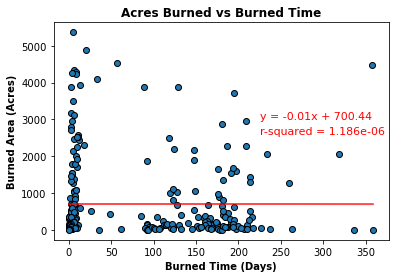

In [6]:
# Define x,y values
area_x_values = days.drop(area_outliers.index)
area_y_values = area.drop(area_outliers.index)

# Calculate the correlation
area_correlation = round(st.pearsonr(area_x_values, area_y_values)[0],5)
print(f"The correlation between burned area (acres) and burned days is {area_correlation}")

# Calculate linear regression values
(area_slope, area_intercept, area_rvalue, area_pvalue, area_stderr) = st.linregress(area_x_values, area_y_values)

# Calculate r-squared
area_r_squared = round(area_rvalue**2,9)
print(f"The r-squared is: {area_r_squared}")

# y = mx + b
area_regress_values = area_x_values * area_slope + area_intercept
area_line_eq = "y = " + str(round(area_slope,2)) + "x + " + str(round(area_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(area_x_values, area_y_values, edgecolors='black')
plt.plot(area_x_values,area_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(area_line_eq,(225,3000), fontsize=11, color="red")
plt.annotate(f'r-squared = {area_r_squared}', (225,2600), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Acres Burned vs Burned Time', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Burned Area (Acres)', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('../Images/day_area.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

### Correlation between Resources vs Burned Time

To find out how many resources required to shorten burned time

#### Resources: Personnel Involved

In [17]:
#Discover wheather personnel involved has relation to burned time
per_inv_t = per_inv_df.loc[per_inv_df['Days Burned']>=0, 'PersonnelInvolved']
pt_days = per_inv_df.loc[per_inv_df['Days Burned']>=0, 'Days Burned']

# Calculate the IQR and quantitatively
pt_quartiles = pt_days.quantile([0.25,0.5,0.75])
pt_lowerq = pt_quartiles[0.25]
pt_upperq = pt_quartiles[0.75]
pt_mean = pt_days.mean()
pt_iqr = pt_upperq-pt_lowerq    
pt_lower_bound = pt_lowerq - (1.5*pt_iqr)
pt_upper_bound = pt_upperq + (1.5*pt_iqr)

# Determine outliers using upper and lower bounds
pt_outliers = per_inv_t.loc[(per_inv_t < pt_lower_bound) | (per_inv_t > pt_upper_bound)]

# Print out the result
print(f'Personnel Involved outliers based on Burned Time')
print(f"Burned Time below {round(pt_lower_bound,2)} could be outliers.")
print(f"Burned Time above {round(pt_upper_bound,2)} could be outliers.")
print(f"Average Burned Time is: {round(pt_mean,2)}")
print(f"Number of outliers is: {pt_outliers.count()}")

Personnel Involved outliers based on Burned Time
Burned Time below -27.0 could be outliers.
Burned Time above 53.0 could be outliers.
Average Burned Time is: 45.33
Number of outliers is: 140


The correlation between burned time (days) and personnel involved is -0.21
The r-squared is: 0.04


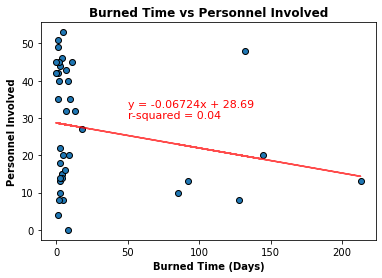

In [21]:
# Define x, y values
pt_x_values = pt_days.drop(pt_outliers.index)
pt_y_values = per_inv_t.drop(pt_outliers.index)

# Calculate the correlation
pt_correlation = round(st.pearsonr(pt_x_values, pt_y_values)[0],2)
print(f"The correlation between burned time (days) and personnel involved is {pt_correlation}")

# Calculate linear regression values
(pt_slope, pt_intercept, pt_rvalue, pt_pvalue, pt_stderr) = st.linregress(pt_x_values, pt_y_values) 
                                                                                                   
# Calculate r-squared
pt_r_squared = round(pt_rvalue**2,2)
print(f"The r-squared is: {pt_r_squared}")

# y = mx + b
pt_regress_values = pt_x_values * pt_slope + pt_intercept
pt_line_eq = "y = " + str(round(pt_slope,5)) + "x + " + str(round(pt_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(pt_x_values, pt_y_values, edgecolors='black')
plt.plot(pt_x_values,pt_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(pt_line_eq,(50,33), fontsize=11, color="red")
plt.annotate(f'r-squared = {pt_r_squared}', (50,30), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Time vs Personnel Involved', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Personnel Involved', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('../Images/time_perinv.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Dozers

In [22]:
#Discover wheather dozers has relation to burned time
dozers_t = dozers_df.loc[dozers_df['Days Burned']>=0, 'Dozers']
dt_days = dozers_df.loc[dozers_df['Days Burned']>=0, 'Days Burned']

# Calculate the IQR and quantitatively
dt_quartiles = dt_days.quantile([0.25,0.5,0.75])
dt_lowerq = dt_quartiles[0.25]
dt_upperq = dt_quartiles[0.75]
dt_mean = dt_days.mean()
dt_iqr = dt_upperq-dt_lowerq    
dt_lower_bound = dt_lowerq - (1.5*dt_iqr)
dt_upper_bound = dt_upperq + (1.5*dt_iqr)

# Determine outliers using upper and lower bounds
dt_outliers = dozers_t.loc[(dozers_t < dt_lower_bound) | (dozers_t > dt_upper_bound)]

# Print out the result
print(f'Dozers outliers based on Burned Time')
print(f"Burned Time below {round(dt_lower_bound,2)} could be outliers.")
print(f"Burned Time above {round(dt_upper_bound,2)} could be outliers.")
print(f"Average Burned Time is: {round(dt_mean,2)}")
print(f"Number of outliers is: {dt_outliers.count()}")

Dozers outliers based on Burned Time
Burned Time below -19.38 could be outliers.
Burned Time above 37.62 could be outliers.
Average Burned Time is: 42.57
Number of outliers is: 2


The correlation between burned time (days) and dozers is -0.14
The r-squared is: 0.02


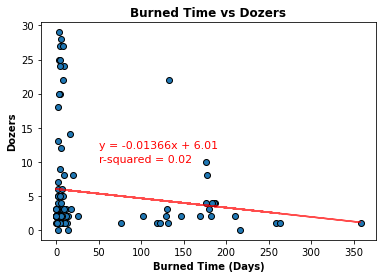

In [27]:
# Define x, y values
dt_x_values = dt_days.drop(dt_outliers.index)
dt_y_values = dozers_t.drop(dt_outliers.index)

# Calculate the correlation
dt_correlation = round(st.pearsonr(dt_x_values, dt_y_values)[0],2)
print(f"The correlation between burned time (days) and dozers is {dt_correlation}")

# Calculate linear regression values
(dt_slope, dt_intercept, dt_rvalue, dt_pvalue, dt_stderr) = st.linregress(dt_x_values, dt_y_values) 
                                                                                                   
# Calculate r-squared
dt_r_squared = round(dt_rvalue**2,2)
print(f"The r-squared is: {dt_r_squared}")

# y = mx + b
dt_regress_values = dt_x_values * dt_slope + dt_intercept
dt_line_eq = "y = " + str(round(dt_slope,5)) + "x + " + str(round(dt_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(dt_x_values, dt_y_values, edgecolors='black')
plt.plot(dt_x_values, dt_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(dt_line_eq,(50,12), fontsize=11, color="red")
plt.annotate(f'r-squared = {dt_r_squared}', (50,10), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Burned Time vs Dozers', fontweight='bold')
plt.xlabel('Burned Time (Days)', fontweight='bold')
plt.ylabel('Dozers', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('../Images/time_dozers.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

### Correlation between Resources vs Final Size Burned

To find out how many resources involved based on burned area

#### Resources: Personnel Involved

In [8]:
#Discover wheather personnel involved has relation to area burned
per_inv = per_inv_df['PersonnelInvolved']
area_pi = per_inv_df['AcresBurned']

# Calculate the IQR and quantitatively
pi_quartiles = area_pi.quantile([0.25,0.5,0.75])
pi_lowerq = pi_quartiles[0.25]
pi_upperq = pi_quartiles[0.75]
pi_mean = area_pi.mean()
pi_iqr = pi_upperq-pi_lowerq    
pi_lower_bound = pi_lowerq - (1.5*pi_iqr)
pi_upper_bound = pi_upperq + (1.5*pi_iqr)

# Determine outliers using upper and lower bounds
pi_outliers = area_pi.loc[(area_pi < pi_lower_bound) | (area_pi > pi_upper_bound)]

# Print out the result
print(f'Area burned outliers based on personel involved')
print(f"Final burned area (arces) below {round(pi_lower_bound,2)} could be outliers.")
print(f"Final burned area (arces) above {round(pi_upper_bound,2)} could be outliers.")
print(f"Average burned area is: {round(pi_mean,2)}")
print(f"Number of outliers is: {pi_outliers.count()}")

Area burned outliers based on personel involved
Final burned area (arces) below -4194.25 could be outliers.
Final burned area (arces) above 7293.75 could be outliers.
Average burned area is: 6009.79
Number of outliers is: 24


The correlation between burned area (acres) and personnel involved is 0.37
The r-squared is: 0.13


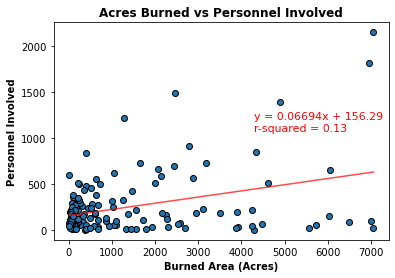

In [9]:
# Define x, y values
per_inv_x_values = area_pi.drop(pi_outliers.index)
per_inv_y_values = per_inv.drop(pi_outliers.index)

# Calculate the correlation
per_inv_correlation = round(st.pearsonr(per_inv_x_values, per_inv_y_values)[0],2)
print(f"The correlation between burned area (acres) and personnel involved is {per_inv_correlation}")

# Calculate linear regression values
(per_inv_slope, per_inv_intercept, per_inv_rvalue, per_inv_pvalue, per_inv_stderr) = st.linregress(per_inv_x_values, 
                                                                                                   per_inv_y_values)

# Calculate r-squared
per_inv_r_squared = round(per_inv_rvalue**2,2)
print(f"The r-squared is: {per_inv_r_squared}")

# y = mx + b
per_inv_regress_values = per_inv_x_values * per_inv_slope + per_inv_intercept
per_inv_line_eq = "y = " + str(round(per_inv_slope,5)) + "x + " + str(round(per_inv_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(per_inv_x_values, per_inv_y_values, edgecolors='black')
plt.plot(per_inv_x_values,per_inv_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(per_inv_line_eq,(4300,1200), fontsize=11, color="red")
plt.annotate(f'r-squared = {per_inv_r_squared}', (4300,1070), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Acres Burned vs Personnel Involved', fontweight='bold')
plt.xlabel('Burned Area (Acres)', fontweight='bold')
plt.ylabel('Personnel Involved', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('../Images/sized_perinv.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Dozers

In [10]:
#Discover wheather dozers has relation to area burned
dozers = dozers_df['Dozers']
area_dz = dozers_df['AcresBurned']

# Calculate the IQR and quantitatively
dozers_quartiles = area_dz.quantile([0.25,0.5,0.75])
dozers_lowerq = dozers_quartiles[0.25]
dozers_upperq = dozers_quartiles[0.75]
dozers_mean = area_dz.mean()
dozers_iqr = dozers_upperq-dozers_lowerq    
dozers_lower_bound = dozers_lowerq - (1.5*dozers_iqr)
dozers_upper_bound = dozers_upperq + (1.5*dozers_iqr)

# Determine outliers using upper and lower bounds
dozers_outliers = area_dz.loc[(area_dz < dozers_lower_bound) | (area_dz > dozers_upper_bound)]

# Print out the result
print(f'Area burned outliers based on dozers involved')
print(f"Final burned area (arces) below {round(dozers_lower_bound,2)} could be outliers.")
print(f"Final burned area (arces) above {round(dozers_upper_bound,2)} could be outliers.")
print(f"Average burned area is: {round(dozers_mean,2)}")
print(f"Number of outliers is: {dozers_outliers.count()}")

Area burned outliers based on dozers involved
Final burned area (arces) below -4327.0 could be outliers.
Final burned area (arces) above 7507.0 could be outliers.
Average burned area is: 8197.18
Number of outliers is: 18


The correlation between burned area (acres) and number of dozers is 0.24
The r-squared is: 0.06


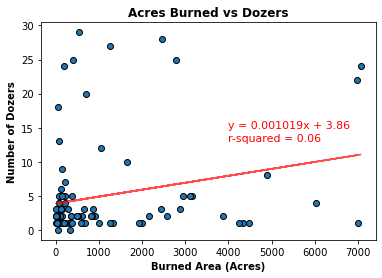

In [11]:
# Define x, y values
dozers_x_values = area_dz.drop(dozers_outliers.index)
dozers_y_values = dozers.drop(dozers_outliers.index)

# Calculate the correlation
dozers_correlation = round(st.pearsonr(dozers_x_values, dozers_y_values)[0],2)
print(f"The correlation between burned area (acres) and number of dozers is {dozers_correlation}")

# Calculate linear regression values
(dozers_slope, dozers_intercept, dozers_rvalue, dozers_pvalue, dozers_stderr) = st.linregress(dozers_x_values, 
                                                                                                   dozers_y_values)

# Calculate r-squared
dozers_r_squared = round(dozers_rvalue**2,2)
print(f"The r-squared is: {dozers_r_squared}")

# y = mx + b
dozers_regress_values = dozers_x_values * dozers_slope + dozers_intercept
dozers_line_eq = "y = " + str(round(dozers_slope,6)) + "x + " + str(round(dozers_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(dozers_x_values, dozers_y_values, edgecolors='black')
plt.plot(dozers_x_values, dozers_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(dozers_line_eq,(4000,15), fontsize=11, color="red")
plt.annotate(f'r-squared = {dozers_r_squared}', (4000,13), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Acres Burned vs Dozers', fontweight='bold')
plt.xlabel('Burned Area (Acres)', fontweight='bold')
plt.ylabel('Number of Dozers', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('../Images/sized_dozers.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Engines

In [12]:
#Discover wheather engines has relation to area burned
engines = eng_df['Engines']
area_en = eng_df['AcresBurned']

# Calculate the IQR and quantitatively
eng_quartiles = area_en.quantile([0.25,0.5,0.75])
eng_lowerq = eng_quartiles[0.25]
eng_upperq = eng_quartiles[0.75]
eng_mean = area_en.mean()
eng_iqr = eng_upperq-eng_lowerq    
eng_lower_bound = eng_lowerq - (1.5*eng_iqr)
eng_upper_bound = eng_upperq + (1.5*eng_iqr)

# Determine outliers using upper and lower bounds
eng_outliers = area_en.loc[(area_en < eng_lower_bound) | (area_en > eng_upper_bound)]

# Print out the result
print(f'Area burned outliers based on engine involved')
print(f"Final burned area (arces) below {round(eng_lower_bound,2)} could be outliers.")
print(f"Final burned area (arces) above {round(eng_upper_bound,2)} could be outliers.")
print(f"Average burned area is: {round(eng_mean,2)}")
print(f"Number of outliers is: {eng_outliers.count()}")

Area burned outliers based on engine involved
Final burned area (arces) below -3533.25 could be outliers.
Final burned area (arces) above 6116.75 could be outliers.
Average burned area is: 5882.66
Number of outliers is: 25


The correlation between burned area (acres) and number of eng is 0.31
The r-squared is: 0.09


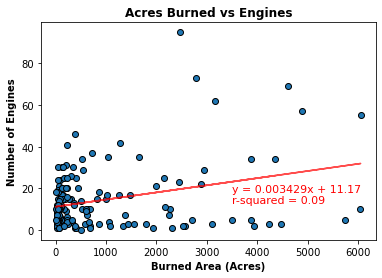

In [13]:
# Define x, y values
eng_x_values = area_en.drop(eng_outliers.index)
eng_y_values = engines.drop(eng_outliers.index)

# Calculate the correlation
eng_correlation = round(st.pearsonr(eng_x_values, eng_y_values)[0],2)
print(f"The correlation between burned area (acres) and number of eng is {eng_correlation}")

# Calculate linear regression values
(eng_slope, eng_intercept, eng_rvalue, eng_pvalue, eng_stderr) = st.linregress(eng_x_values, eng_y_values)

# Calculate r-squared
eng_r_squared = round(eng_rvalue**2,2)
print(f"The r-squared is: {eng_r_squared}")

# y = mx + b
eng_regress_values = eng_x_values * eng_slope + eng_intercept
eng_line_eq = "y = " + str(round(eng_slope,6)) + "x + " + str(round(eng_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(eng_x_values, eng_y_values, edgecolors='black')
plt.plot(eng_x_values, eng_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(eng_line_eq,(3500,18), fontsize=11, color="red")
plt.annotate(f'r-squared = {eng_r_squared}', (3500,13), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Acres Burned vs Engines', fontweight='bold')
plt.xlabel('Burned Area (Acres)', fontweight='bold')
plt.ylabel('Number of Engines', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('../Images/sized_eng.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()

#### Resources: Water Tenders

In [14]:
#Discover wheather water tenders has relation to area burned
water = water_df['WaterTenders']
area_wt = water_df['AcresBurned']

# Calculate the IQR and quantitatively
water_quartiles = area_wt.quantile([0.25,0.5,0.75])
water_lowerq = water_quartiles[0.25]
water_upperq = water_quartiles[0.75]
water_mean = area_en.mean()
water_iqr = water_upperq-water_lowerq    
water_lower_bound = water_lowerq - (1.5*water_iqr)
water_upper_bound = water_upperq + (1.5*water_iqr)

# Determine outliers using upper and lower bounds
water_outliers = area_wt.loc[(area_wt < water_lower_bound) | (area_wt > water_upper_bound)]

# Print out the result
print(f'Area burned outliers based on Water Tenders involved')
print(f"Final burned area (arces) below {round(water_lower_bound,2)} could be outliers.")
print(f"Final burned area (arces) above {round(water_upper_bound,2)} could be outliers.")
print(f"Average burned area is: {round(water_mean,2)}")
print(f"Number of outliers is: {water_outliers.count()}")

Area burned outliers based on Water Tenders involved
Final burned area (arces) below -3844.75 could be outliers.
Final burned area (arces) above 6659.25 could be outliers.
Average burned area is: 5882.66
Number of outliers is: 21


The correlation between burned area (acres) and number of water is 0.1
The r-squared is: 0.01


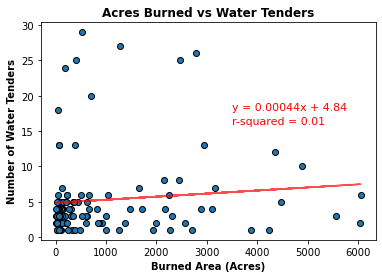

In [15]:
# Define x, y values
water_x_values = area_wt.drop(water_outliers.index)
water_y_values = water.drop(water_outliers.index)

# Calculate the correlation
water_correlation = round(st.pearsonr(water_x_values, water_y_values)[0],2)
print(f"The correlation between burned area (acres) and number of water is {water_correlation}")

# Calculate linear regression values
(water_slope, water_intercept, water_rvalue, water_pvalue, water_stderr) = st.linregress(water_x_values, water_y_values)

# Calculate r-squared
water_r_squared = round(water_rvalue**2,2)
print(f"The r-squared is: {water_r_squared}")

# y = mx + b
water_regress_values = water_x_values * water_slope + water_intercept
water_line_eq = "y = " + str(round(water_slope,5)) + "x + " + str(round(water_intercept,2))

# Gernerate scatter chart with liner regression line, equation of line, r-squared value
plt.scatter(water_x_values, water_y_values, edgecolors='black')
plt.plot(water_x_values, water_regress_values, color='r', alpha=0.7)

# Plot the Annotation in the graph 
plt.annotate(water_line_eq,(3500,18), fontsize=11, color="red")
plt.annotate(f'r-squared = {water_r_squared}', (3500,16), fontsize=11, color="red")

# Define title and x/y labels
plt.title('Acres Burned vs Water Tenders', fontweight='bold')
plt.xlabel('Burned Area (Acres)', fontweight='bold')
plt.ylabel('Number of Water Tenders', fontweight='bold')

# Save box plot graph to Images folder
plt.savefig('../Images/sized_water.png')

# Present the box plot chart
plt.show()

# To close pyplot
plt.close()